In [1]:
# Imports libraries for math operations, pandas dataframes, and data processing
import pandas as pd
import numpy as np

# Imports libraries for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Imports a library for the user interface
from ipywidgets import interact, interactive, Layout, Dropdown, IntSlider, Checkbox, fixed

# Imports library for saving plots
import os

# Sets plotting theme to seaborn
sns.set()

### Loading and merging dataframes

In [2]:
def load_data(file, sheet):
    """
    Takes as input an Excel file name and sheet name and loads datasets of geometry and architecture parameters into 
    dataframes and merges them. Returns the merged dataframe.
    
    Parameters:
    file: Excel file name
    sheet: sheet name within `file`
    
    Returns:
    merged_df: a dataframe containing geometry and architecture parameters
    """
    # Creates a dataframe of geometry parameters
    geo_df = pd.read_excel(io=file, sheet_name=sheet)
    geo_df.drop(columns=['DOI', 'Cathode 3D \nCharateristic Note', 'Anode 3D \nCharateristic Note', 'SA/V [1/µm]', 'SA gain'], 
                inplace=True)
    cols = list(geo_df.columns)
    new_cols = ['Paper', 'Set', 'Full Cell Thickness [µm]', 'Cathode Thickness [µm]', 'Anode Thickness [µm]', 
               'Separator Thickness [µm]', 'Cathode Length [µm]', 'Anode Length [µm]']
    rename_cols = dict(zip(cols, new_cols))
    geo_df.rename(columns=rename_cols, inplace=True)
    
    # Creates a dataframe of architecture parameters
    arch_df = pd.read_excel('3D_Battery_Parameter_Log.xls', sheet_name='GeneralInformation', nrows=100)
    arch_df.rename(columns={'Paper #': 'Paper'}, inplace=True)
    archs = list(arch_df.columns[[3,5,7]])
    gen_archs = list(arch_df.columns[[4,6,8]])
    remove_cols = list(arch_df.columns[-15:len(arch_df.columns)])
    remove_cols.append('DOI')
    remove_cols += archs
    arch_df.drop(columns=remove_cols, inplace=True)
    rename_cols = dict(zip(gen_archs, archs))
    arch_df.rename(columns=rename_cols, inplace=True)
    arch_df.drop(arch_df[arch_df['Overall Architecture'] == '3D Concentric'].index, inplace = True)
    
    # Merges the two dataframes
    merged_df = pd.merge(geo_df, arch_df, on=['Paper', 'Set'])
    for col in merged_df.columns[:8]:
        merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')
        
    return merged_df

In [3]:
file='3D_Battery_Parameter_Log.xls'
sheet='GeometryParameters'
merged_df = load_data(file, sheet)

In [5]:
merged_df.head()

,Paper,Set,Full Cell Thickness [µm],Cathode Thickness [µm],Anode Thickness [µm],Separator Thickness [µm],Cathode Length [µm],Anode Length [µm],Overall Architecture,Cathode Architecture,Anode Architecture
0,1,1,NaN,500.0,NaN,NaN,100.0,NaN,2.5D,Solid Column,1D
1,2,1,NaN,NaN,215.0,NaN,NaN,NaN,2.5D,1D,Coated Lattice
2,2,2,NaN,NaN,415.0,NaN,NaN,NaN,2.5D,1D,Coated Lattice
3,2,3,NaN,NaN,265.0,NaN,NaN,NaN,2.5D,1D,Coated Lattice
4,2,4,NaN,NaN,473.0,NaN,NaN,NaN,2.5D,1D,Coated Lattice


### Getting architecture types and architecture strings

In [6]:
def get_archs(merged_df):
    """
    Takes as input a dataframe and returns a list of lists of architectures and a list of 
    strings for each architecture type.
    
    Parameter:
    merged_df: dataframe
    
    Returns:
    archs: a list of lists of architectures
    arch_strings: a list of strings for each architecture type
    """
    # Creates a list of values for each parameter
    #full_cell_thickness = merged_df['Full Cell Thickness [µm]'].values
    #cathode_thickness = merged_df['Cathode Thickness [µm]'].values
    #anode_thickness = merged_df['Anode Thickness [µm]'].values
    #sep_thickness = merged_df['Separator Thickness [µm]'].values
    #cathode_length = merged_df['Cathode Length [µm]'].values
    #anode_length = merged_df['Anode Length [µm]'].values

    # Creates a list of architectures for each type: overall, cathode, and anode
    #return merged_df
    overall_arch = list(np.unique(list(merged_df['Overall Architecture'])))
    cathode_arch = list(np.unique(list(merged_df['Cathode Architecture'].values)))
    cathode_arch.remove('nan')
    anode_arch = list(np.unique(list(merged_df['Anode Architecture'].values)))
    anode_arch.remove('nan')
    
    # Creates a list of lists of architectures
    archs = [overall_arch, cathode_arch, anode_arch]
    # Creates a list of strings for each architecture type
    arch_strings = ['Overall Architecture', 'Cathode Architecture', 'Anode Architecture']
    
    return archs, arch_strings

In [7]:
archs, arch_strings = get_archs(merged_df)
print(archs)
print()
print(arch_strings)

[['2.5D', 'Interdigitated'], ['1D', 'Coated Column', 'Coated Network', 'Electrolyte channel', 'Int plate', 'Nanotube', 'Solid Column'], ['1D', 'Coated Column', 'Coated Lattice', 'Electrolyte channel', 'Int plate', 'Solid Column']]

['Overall Architecture', 'Cathode Architecture', 'Anode Architecture']


### Getting parameters and errors for a given architecture type

In [8]:
def get_params(merged_df, arch_type):
    """
    Takes as input a dataframe and an architecture type and returns a list of values of each parameter and 
    the errors for each architecture type.
    
    Parameters:
    merged_df: dataframe
    arch_type: architecture type
            - Options: 'Overall Architecture', 'Cathode Architecture', 'Anode Architecture'
    
    Returns:
    params: a list of lists of values for each parameter
    errors: a list of lists of errors for each parameter
    """
    archs, arch_strings = get_archs(merged_df)
    param_strings = ['Average Full Cell Thickness', 'Average Cathode Thickness', 'Average Anode Thickness', 
                     'Average Separator Thickness', 'Average Cathode Length', 'Average Anode Length']
    
    i = arch_strings.index(arch_type)
    
    avg_full_cell_thicknesses = []
    full_cell_thickness_errors = []
    
    avg_cathode_thicknesses = []
    cathode_thickness_errors = []
    
    avg_anode_thicknesses = []
    anode_thickness_errors = []
    
    avg_sep_thicknesses = []
    sep_thickness_errors = []
    
    avg_cathode_lengths = []
    cathode_length_errors = []
    
    avg_anode_lengths = []
    anode_length_errors = []
    
    for arch in archs[i]:
        # Full cell thickness
        avg_full_cell_thickness = merged_df[merged_df[arch_strings[i]] == arch]['Full Cell Thickness [µm]'].mean()
        avg_full_cell_thicknesses.append(avg_full_cell_thickness)
        
        min_full_cell_thickness = merged_df[merged_df[arch_strings[i]] == arch]['Full Cell Thickness [µm]'].min()
        max_full_cell_thickness = merged_df[merged_df[arch_strings[i]] == arch]['Full Cell Thickness [µm]'].max()
        full_cell_thickness_errors.append([avg_full_cell_thickness - min_full_cell_thickness, 
                                           max_full_cell_thickness - avg_full_cell_thickness])
        
        # Cathode thickness
        avg_cathode_thickness = merged_df[merged_df[arch_strings[i]] == arch]['Cathode Thickness [µm]'].mean()
        avg_cathode_thicknesses.append(avg_cathode_thickness)
        
        min_cathode_thickness = merged_df[merged_df[arch_strings[i]] == arch]['Cathode Thickness [µm]'].min()
        max_cathode_thickness = merged_df[merged_df[arch_strings[i]] == arch]['Cathode Thickness [µm]'].max()
        cathode_thickness_errors.append([avg_cathode_thickness - min_cathode_thickness, 
                                           max_cathode_thickness - avg_cathode_thickness])
        
        # Anode thickness
        avg_anode_thickness = merged_df[merged_df[arch_strings[i]] == arch]['Anode Thickness [µm]'].mean()
        avg_anode_thicknesses.append(avg_anode_thickness)
        
        min_anode_thickness = merged_df[merged_df[arch_strings[i]] == arch]['Anode Thickness [µm]'].min()
        max_anode_thickness = merged_df[merged_df[arch_strings[i]] == arch]['Anode Thickness [µm]'].max()
        anode_thickness_errors.append([avg_anode_thickness - min_anode_thickness, 
                                           max_anode_thickness - avg_anode_thickness])
        
        # Separator thickness
        avg_sep_thickness = merged_df[merged_df[arch_strings[i]] == arch]['Separator Thickness [µm]'].mean()
        avg_sep_thicknesses.append(avg_sep_thickness)
        
        min_sep_thickness = merged_df[merged_df[arch_strings[i]] == arch]['Separator Thickness [µm]'].min()
        max_sep_thickness = merged_df[merged_df[arch_strings[i]] == arch]['Separator Thickness [µm]'].max()
        sep_thickness_errors.append([avg_sep_thickness - min_sep_thickness, 
                                           max_sep_thickness - avg_sep_thickness])
        
        # Cathode length
        avg_cathode_length = merged_df[merged_df[arch_strings[i]] == arch]['Cathode Length [µm]'].mean()
        avg_cathode_lengths.append(avg_cathode_length)
        
        min_cathode_length = merged_df[merged_df[arch_strings[i]] == arch]['Cathode Length [µm]'].min()
        max_cathode_length = merged_df[merged_df[arch_strings[i]] == arch]['Cathode Length [µm]'].max()
        cathode_length_errors.append([avg_cathode_length - min_cathode_length, 
                                           max_cathode_length - avg_cathode_length])
        
        # Anode length
        avg_anode_length = merged_df[merged_df[arch_strings[i]] == arch]['Anode Length [µm]'].mean()
        avg_anode_lengths.append(avg_anode_length)
        
        min_anode_length = merged_df[merged_df[arch_strings[i]] == arch]['Anode Length [µm]'].min()
        max_anode_length = merged_df[merged_df[arch_strings[i]] == arch]['Anode Length [µm]'].max()
        anode_length_errors.append([avg_anode_length - min_anode_length, 
                                           max_anode_length - avg_anode_length])
        
    full_cell_thickness_errors = np.transpose(full_cell_thickness_errors)
    cathode_thickness_errors = np.transpose(cathode_thickness_errors)
    anode_thickness_errors = np.transpose(anode_thickness_errors)
    sep_thickness_errors = np.transpose(sep_thickness_errors)
    cathode_length_errors = np.transpose(cathode_length_errors)
    anode_length_errors = np.transpose(anode_length_errors)
    
    params = [avg_full_cell_thicknesses, avg_cathode_thicknesses, avg_anode_thicknesses, avg_sep_thicknesses, 
              avg_cathode_lengths, avg_anode_lengths]
    
    errors = [full_cell_thickness_errors, cathode_thickness_errors, anode_thickness_errors, sep_thickness_errors, 
              cathode_length_errors, anode_length_errors]
    
    return params, errors

In [10]:
params, errors = get_params(merged_df, 'Overall Architecture')
print(params)
print()
print(errors)

[[1.2833333333333334, 100.06400000000001], [171.89705882352942, 110.73368421052629], [164.10000000000002, 121.69099999999999], [10.048214285714286, 46.005], [227.01250000000002, 12.24465], [102.66666666666667, 24.419047619047618]]

[array([[  0.88333333,  99.904     ],
       [  4.41666667, 379.936     ]]), array([[171.79705882, 110.66368421],
       [378.10294118, 949.26631579]]), array([[164.   , 121.681],
       [655.9  , 938.309]]), array([[10.02321429, 45.98      ],
       [39.95178571, 53.995     ]]), array([[ 226.5125 ,   12.22765],
       [2272.9875 ,   37.75535]]), array([[102.46666667,  24.21904762],
       [397.33333333,  25.58095238]])]


### Plotting average parameters

In [11]:
def plot_geo_params(merged_df, arch_type, param, save_plot):
    """
    Takes as input an architecture type and parameter and produces plots of the input parameter vs. 
    all other parameters.
    
    Parameters:
    merged_df: dataframe
    arch_type: architecture type
            - Options: 'Overall Architecture', 'Cathode Architecture', 'Anode Architecture'
    param: parameter to be plotted on the y-axis vs. all other parameters
            - Options: 'Average Full Cell Thickness', 'Average Cathode Thickness', 'Average Anode Thickness', 
                     'Average Separator Thickness', 'Average Cathode Length', 'Average Anode Length'
    save_plot: (boolean) whether or not to save the figure to a PDF file
    
    Returns:
    5 plots
    """
    params, errors = get_params(merged_df, arch_type)
    param_strings = ['Average Full Cell Thickness', 'Average Cathode Thickness', 'Average Anode Thickness', 
                     'Average Separator Thickness', 'Average Cathode Length', 'Average Anode Length']
    archs, arch_strings = get_archs(merged_df)
    
    i = arch_strings.index(arch_type)
    j = param_strings.index(param)
    
    y = params[j]
    del params[j]
    y_string = param_strings[j]
    del param_strings[j]
    y_error = errors[j]
    del errors[j]
    
    matplotlib.rcParams.update({'font.size': 20})
    
    fig, axes = plt.subplots(figsize=(8,30), nrows=len(params), ncols=1)
    fig.suptitle(f'{arch_strings[i]} - {y_string}', fontsize=20)
    
    # Plots data
    for k in range(len(params)):
        axes[k].errorbar(params[k], y, 
                     xerr=errors[k], yerr=y_error, 
                     marker='o', linestyle='', color='red', ecolor='black')
        axes[k].set_title(f'{arch_strings[i]}: {y_string} vs. {param_strings[k]}')
        axes[k].set_xlabel(f'{param_strings[k]} [µm]')
        axes[k].set_ylabel(f'{y_string} [µm]')
        for index, text in enumerate(archs[i]):
            axes[k].annotate(text, (params[k][index], y[index]), fontsize=10)
            
    if save_plot:
        if not os.path.isdir(f'{arch_strings[i]}'):
            os.mkdir(f'{arch_strings[i]}')
        if not os.path.isfile(f'{arch_strings[i]}/{y_string}.pdf'):
            plt.savefig(f'{arch_strings[i]}/{y_string}.pdf')

In [13]:
#plot_geo_params(merged_df, 'Anode Architecture', 'Average Anode Thickness', False)

### Interactive plotting of average parameters

In [14]:
def interactive_plot_geo_params(df, save_fig=False):
    """
    Displays plots of geometry parameters.
    
    Parameters:
    df: dataframe
    save_fig: (boolean) whether or not to save the figure to a PDF file
            - Default: False
    """
    arch_strings = ['Overall Architecture', 'Cathode Architecture', 'Anode Architecture']
    param_strings = ['Average Full Cell Thickness', 'Average Cathode Thickness', 'Average Anode Thickness', 
                     'Average Separator Thickness', 'Average Cathode Length', 'Average Anode Length']
    plot = interact(plot_geo_params, 
                    merged_df=fixed(df), 
                    arch_type=Dropdown(options=arch_strings, value='Overall Architecture', description='Architecture type'), 
                    param=Dropdown(options=param_strings, value='Average Full Cell Thickness', description='Parameter'), 
                    save_plot=Checkbox(save_fig, description='Save figure')
            )
    
    display(plot)

In [17]:
#interactive_plot_geo_params(merged_df, save_fig=False)

### Save plots of average parameters

In [62]:
def save_plots():
    """
    Saves plots of geometry parameters for each architecture type.
    """
    arch_strings = ['Overall Architecture', 'Cathode Architecture', 'Anode Architecture']
    param_strings = ['Average Full Cell Thickness', 'Average Cathode Thickness', 'Average Anode Thickness', 
                     'Average Separator Thickness', 'Average Cathode Length', 'Average Anode Length']
    for arch_type in arch_strings:
        for param in param_strings:
            plot_geo_params(arch_type, param, save_plot=True)

In [16]:
#save_plots()

---

---

### Plotting all parameters

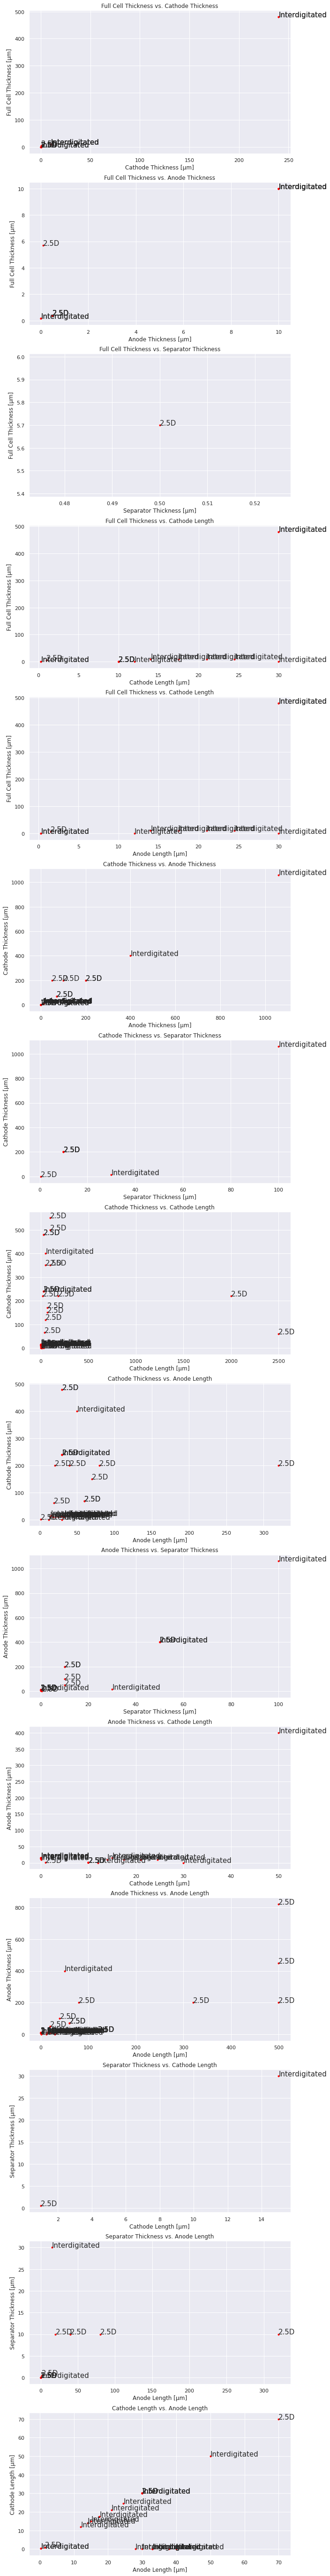

In [330]:
fig = plt.figure(figsize=(10,100))
axes = fig.subplots(nrows=15, ncols=1)
#plt.tight_layout()

axes[0].plot(cathode_thickness, full_cell_thickness, marker='.', linestyle='', color='red')
axes[0].set_title('Full Cell Thickness vs. Cathode Thickness')
axes[0].set_xlabel('Cathode Thickness [µm]')
axes[0].set_ylabel('Full Cell Thickness [µm]')
for index, text in enumerate(overall_arc):
    axes[0].annotate(text, (cathode_thickness[index], full_cell_thickness[index]), fontsize=15)
    
axes[1].plot(anode_thickness, full_cell_thickness, marker='.', linestyle='', color='red')
axes[1].set_title('Full Cell Thickness vs. Anode Thickness')
axes[1].set_xlabel('Anode Thickness [µm]')
axes[1].set_ylabel('Full Cell Thickness [µm]')
for index, text in enumerate(overall_arc):
    axes[1].annotate(text, (anode_thickness[index], full_cell_thickness[index]), fontsize=15)
    
axes[2].plot(sep_thickness, full_cell_thickness, marker='.', linestyle='', color='red')
axes[2].set_title('Full Cell Thickness vs. Separator Thickness')
axes[2].set_xlabel('Separator Thickness [µm]')
axes[2].set_ylabel('Full Cell Thickness [µm]')
for index, text in enumerate(overall_arc):
    axes[2].annotate(text, (sep_thickness[index], full_cell_thickness[index]), fontsize=15)
    
axes[3].plot(cathode_length, full_cell_thickness, marker='.', linestyle='', color='red')
axes[3].set_title('Full Cell Thickness vs. Cathode Length')
axes[3].set_xlabel('Cathode Length [µm]')
axes[3].set_ylabel('Full Cell Thickness [µm]')
for index, text in enumerate(overall_arc):
    axes[3].annotate(text, (cathode_length[index], full_cell_thickness[index]), fontsize=15)
    
axes[4].plot(anode_length, full_cell_thickness, marker='.', linestyle='', color='red')
axes[4].set_title('Full Cell Thickness vs. Cathode Length')
axes[4].set_xlabel('Anode Length [µm]')
axes[4].set_ylabel('Full Cell Thickness [µm]')
for index, text in enumerate(overall_arc):
    axes[4].annotate(text, (anode_length[index], full_cell_thickness[index]), fontsize=15)
    
axes[5].plot(anode_thickness, cathode_thickness, marker='.', linestyle='', color='red')
axes[5].set_title('Cathode Thickness vs. Anode Thickness')
axes[5].set_xlabel('Anode Thickness [µm]')
axes[5].set_ylabel('Cathode Thickness [µm]')
for index, text in enumerate(overall_arc):
    axes[5].annotate(text, (anode_thickness[index], cathode_thickness[index]), fontsize=15)
    
axes[6].plot(sep_thickness, cathode_thickness, marker='.', linestyle='', color='red')
axes[6].set_title('Cathode Thickness vs. Separator Thickness')
axes[6].set_xlabel('Separator Thickness [µm]')
axes[6].set_ylabel('Cathode Thickness [µm]')
for index, text in enumerate(overall_arc):
    axes[6].annotate(text, (sep_thickness[index], cathode_thickness[index]), fontsize=15)
    
axes[7].plot(cathode_length, cathode_thickness, marker='.', linestyle='', color='red')
axes[7].set_title('Cathode Thickness vs. Cathode Length')
axes[7].set_xlabel('Cathode Length [µm]')
axes[7].set_ylabel('Cathode Thickness [µm]')
for index, text in enumerate(overall_arc):
    axes[7].annotate(text, (cathode_length[index], cathode_thickness[index]), fontsize=15)
    
axes[8].plot(anode_length, cathode_thickness, marker='.', linestyle='', color='red')
axes[8].set_title('Cathode Thickness vs. Anode Length')
axes[8].set_xlabel('Anode Length [µm]')
axes[8].set_ylabel('Cathode Thickness [µm]')
for index, text in enumerate(overall_arc):
    axes[8].annotate(text, (anode_length[index], cathode_thickness[index]), fontsize=15)
    
axes[9].plot(sep_thickness, anode_thickness, marker='.', linestyle='', color='red')
axes[9].set_title('Anode Thickness vs. Separator Thickness')
axes[9].set_xlabel('Separator Thickness [µm]')
axes[9].set_ylabel('Anode Thickness [µm]')
for index, text in enumerate(overall_arc):
    axes[9].annotate(text, (sep_thickness[index], anode_thickness[index]), fontsize=15)
    
axes[10].plot(cathode_length, anode_thickness, marker='.', linestyle='', color='red')
axes[10].set_title('Anode Thickness vs. Cathode Length')
axes[10].set_xlabel('Cathode Length [µm]')
axes[10].set_ylabel('Anode Thickness [µm]')
for index, text in enumerate(overall_arc):
    axes[10].annotate(text, (cathode_length[index], anode_thickness[index]), fontsize=15)
    
axes[11].plot(anode_length, anode_thickness, marker='.', linestyle='', color='red')
axes[11].set_title('Anode Thickness vs. Anode Length')
axes[11].set_xlabel('Anode Length [µm]')
axes[11].set_ylabel('Anode Thickness [µm]')
for index, text in enumerate(overall_arc):
    axes[11].annotate(text, (anode_length[index], anode_thickness[index]), fontsize=15)
    
axes[12].plot(cathode_length, sep_thickness, marker='.', linestyle='', color='red')
axes[12].set_title('Separator Thickness vs. Cathode Length')
axes[12].set_xlabel('Cathode Length [µm]')
axes[12].set_ylabel('Separator Thickness [µm]')
for index, text in enumerate(overall_arc):
    axes[12].annotate(text, (cathode_length[index], sep_thickness[index]), fontsize=15)
    
axes[13].plot(anode_length, sep_thickness, marker='.', linestyle='', color='red')
axes[13].set_title('Separator Thickness vs. Anode Length')
axes[13].set_xlabel('Anode Length [µm]')
axes[13].set_ylabel('Separator Thickness [µm]')
for index, text in enumerate(overall_arc):
    axes[13].annotate(text, (anode_length[index], sep_thickness[index]), fontsize=15)
    
axes[14].plot(anode_length, cathode_length, marker='.', linestyle='', color='red')
axes[14].set_title('Cathode Length vs. Anode Length')
axes[14].set_xlabel('Anode Length [µm]')
axes[14].set_ylabel('Cathode Length [µm]')
for index, text in enumerate(overall_arc):
    axes[14].annotate(text, (anode_length[index], cathode_length[index]), fontsize=15)
    

#full_cell_thickness
#cathode_thickness
#anode_thickness
#sep_thickness
#cathode_length
#anode_length

In [146]:
mat_df = pd.read_excel('3D_Battery_Parameter_Log.xls', sheet_name='MaterialParameters')
mat_df.rename(columns={'Paper #': 'Paper'}, inplace=True)
mat_df.drop(columns=['DOI', 'Person'], inplace=True)

In [147]:
mat_df.head()

,Paper,Set,Cathode Material,Anode Material,Electrolyte Material,Cathode \nParticle Max. \nDiameter [µm],Cathode \nParticle Ave.\nDiameter [µm],Cathode \nParticle Min. \nDiameter [µm],Anode \nParticle Max. \nDiameter [µm],Anode \nParticle Ave. \nDiameter [µm],Anode \nParticle Min. \nDiameter [µm],Cathode \nElectric \nConductivity [S/cm],Anode \nElectric \nConductivity [S/cm],Electrolyte \nElectric \nConductivity [S/cm],Cathode \nDiffusivity \n[cm^2/s],Anode \nDiffusivity \n[cm^2/s],Electrolyte \nDiffusivity \n[cm^2/s]
0,1,1,LiFePO4,Lithium,Ionogel,N/R,NaN,NaN,N/R,NaN,NaN,0.05,N/R,0.002,N/R,N/R,N/R
1,2,1,Lithium foil,Silver,1M LiPF6 in EC:PC:EMC 1:1:3,N/R,N/R,N/R,0.03,N/R,0.05,N/R,N/R,N/R,N/R,N/R,N/R
2,2,2,Lithium foil,Silver,1M LiPF6 in EC:PC:EMC 1:1:3,N/R,N/R,N/R,0.03,N/R,0.05,N/R,N/R,N/R,N/R,N/R,N/R
3,2,3,Lithium foil,Silver,1M LiPF6 in EC:PC:EMC 1:1:3,N/R,N/R,N/R,0.03,N/R,0.05,N/R,N/R,N/R,N/R,N/R,N/R
4,2,4,Lithium foil,Silver,1M LiPF6 in EC:PC:EMC 1:1:3,N/R,N/R,N/R,0.03,N/R,0.05,N/R,N/R,N/R,N/R,N/R,N/R
